# AutoML approach
its interesting to cross check some of our findings from simple linear regression with more complex models. It can be challenging to iterate through the many possible models, but the advent of low code auto ML libraries like pycaret and H2O make it easier.

In [1]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 2: Initialize H2O

In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_422"; OpenJDK Runtime Environment (build 1.8.0_422-8u422-b05-1~22.04-b05); OpenJDK 64-Bit Server VM (build 25.422-b05, mixed mode)
  Starting server from /home/noone/.cache/pypoetry/virtualenvs/dominos-senior-data-scientist-mPMyyBsO-py3.11/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpuucblhts
  JVM stdout: /tmp/tmpuucblhts/h2o_noone_started_from_python.out
  JVM stderr: /tmp/tmpuucblhts/h2o_noone_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Australia/Brisbane
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.4
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_noone_0lu63o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,26.64 Gb
H2O_cluster_total_cores:,32
H2O_cluster_allowed_cores:,32
H2O_cluster_status:,"locked, healthy"


# Step 3: Load Data

In [3]:
data_path = './../data/price_elasticity_data.csv'
df = pd.read_csv(data_path)

# Step 4: Preprocess Data

In [4]:
# rename columns for convenience
df.rename(columns={'Menu_Price': 'unit_price', 'Pizza_Count': 'quantity', 'Profit_Percentage': 'profit_percentage'}, inplace=True)
df['gross_margin'] = df['profit_percentage'] / 100
df['gross_profit'] = df['unit_price'] * (1 - df['gross_margin'])
df['cost'] = df['unit_price'] - df['gross_profit']

# subset the dataframe for 'Individuale' product and create a copy
individuale_df = df[df['Product'] == 'Individuale'].copy()

# Remove outliers

In [5]:
# todo: remove outliers using IQR

def identify_outliers(df, column):
	"""
     Identify outliers in a specified column of a DataFrame using the 
     Interquartile Range (IQR) method.
     
     The function calculates the first quartile (Q1) and the third quartile 
     (Q3) of the specified column. The interquartile range (IQR) is then 
     computed as the difference between Q3 and Q1.
    
     Outliers are defined as data points that fall below Q1 - 1.5 * IQR or 
     above Q3 + 1.5 * IQR. The function returns the rows containing these  
     outliers along with the calculated lower and upper bounds.

    :param df: 
    :param column: 
    :return: tuple: A tuple containing:
        - pandas.DataFrame: A DataFrame containing the rows identified as outliers.
        - float: The lower bound for identifying outliers.
        - float: The upper bound for identifying outliers.
    """
	Q1 = df[column].quantile(0.25)
	Q3 = df[column].quantile(0.75)
	IQR = Q3 - Q1
	lower_bound = Q1 - 1.5 * IQR
	upper_bound = Q3 + 1.5 * IQR
	return df[(df[column] < lower_bound) | (df[column] > upper_bound)], lower_bound, upper_bound


In [ ]:
individuale_outliers, indiv_lower, indiv_upper = identify_outliers(df[df['Product'] == 'Individuale'], 'unit_price')

individuale_df = individuale_df.drop(individuale_outliers[individuale_outliers['unit_price'] > indiv_upper].index)

individuale_df = individuale_df.drop(individuale_outliers[individuale_outliers['unit_price'] < indiv_lower].index)

# Feature Engineering

### create interaction features

In [6]:
individuale_df['unit_price_squared'] = individuale_df['unit_price'] ** 2
individuale_df['unit_price_cost_interaction'] = individuale_df['unit_price'] * individuale_df['cost']

### normalize features

In [7]:
individuale_df['unit_price_scaled'] = (individuale_df['unit_price'] - individuale_df['unit_price'].mean()) / individuale_df['unit_price'].std()
individuale_df['cost_scaled'] = (individuale_df['cost'] - individuale_df['cost'].mean()) / individuale_df['cost'].std()

In [8]:
# convert to H2O frame
h2o_df = h2o.H2OFrame(individuale_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [9]:
# add scaled features to H2O frame
h2o_df['unit_price_scaled'] = h2o_df['unit_price_scaled']
h2o_df['cost_scaled'] = h2o_df['cost_scaled']

# step 5: Run H2O AutoML

In [10]:
%%time
x = ['unit_price', 'cost', 'gross_margin', 'unit_price_squared', 'unit_price_cost_interaction', 'unit_price_scaled', 'cost_scaled']
y = 'quantity'

aml = H2OAutoML(
    max_runtime_secs=1200, 
    seed=42, 
    project_name="price_elasticity", 
    nfolds=0  # our dataset is too small for cross validation
)

aml.train(
    x=x, 
    y=y, 
    training_frame=h2o_df
)

# view the leaderboard
lb = aml.leaderboard
print(lb)

AutoML progress: |
21:21:35.475: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 60.0.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                 rmse         mse        mae       rmsle    mean_residual_deviance
GBM_grid_1_AutoML_1_20240805_212134_model_446       0.034698   0.00120395  0.0267336  0.00595661                0.00120395
XGBoost_grid_1_AutoML_1_20240805_212134_model_1779  0.0351298  0.0012341   0.0258064  0.00599728                0.0012341
XGBoost_grid_1_AutoML_1_20240805_212134_model_3275  0.0351566  0.00123598  0.0234536  0.00601135                0.00123598
GBM_grid_1_AutoML_1_20240805_212134_model_327       0.0363668  0.00132254  0.0304005  0.00620006                0.00132254
GBM_grid_1_AutoML_1_20240805_212134_model_5         0.0364624  0.0013295   0.0300174  0.0062186                 0.0013295
GBM_grid_1_Auto

# Step 6: Calculate Predictions

In [11]:
best_model = aml.leader
preds = best_model.predict(h2o_df)
individuale_df['predicted_quantity'] = h2o.as_list(preds)['predict']  # add preds to df

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/home/noone/.cache/pypoetry/virtualenvs/dominos-senior-data-scientist-mPMyyBsO-py3.11/lib/python3.11/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


# Step 7: Find Optimal Price to Maximize Gross Profit

In [12]:
individuale_df['gross_profit_predictions'] = (individuale_df['unit_price'] - individuale_df['cost']) * individuale_df['predicted_quantity']

# find price that maximises GP
optimal_price = individuale_df.loc[individuale_df['gross_profit_predictions'].idxmax(), 'unit_price']
max_gross_profit = individuale_df['gross_profit_predictions'].max()
optimal_quantity = individuale_df.loc[individuale_df['gross_profit_predictions'].idxmax(), 'predicted_quantity']

In [13]:
print(f'Optimal Price: {optimal_price}')
print(f'Maximum Gross Profit: {max_gross_profit}')
print(f'Optimal Quantity: {optimal_quantity}')

Optimal Price: 18.61
Maximum Gross Profit: 38.823097055900256
Optimal Quantity: 4.729183860931184


# Plot the relationship between unit price and quantity

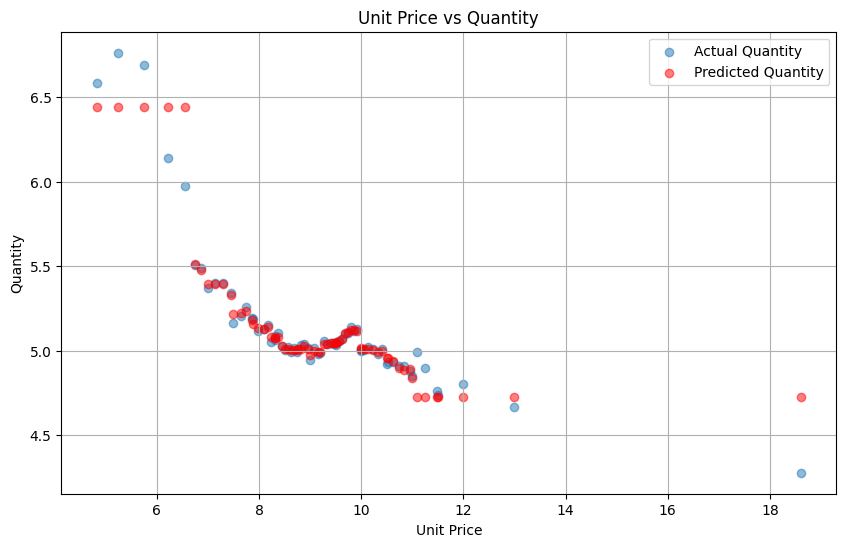

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(
    individuale_df['unit_price'], 
    individuale_df['quantity'], 
    alpha=0.5, 
    label='Actual Quantity'
)
plt.scatter(
    individuale_df['unit_price'], 
    individuale_df['predicted_quantity'], 
    color='red', 
    alpha=0.5, 
    label='Predicted Quantity'
)
plt.plot(
    individuale_df['unit_price'], 
    individuale_df['predicted_quantity'], 
    color='blue', 
    linewidth=2, 
    label='Regression Line'
)
plt.title('Unit Price vs Quantity')
plt.xlabel('Unit Price')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()

# Plot the gross profit curve

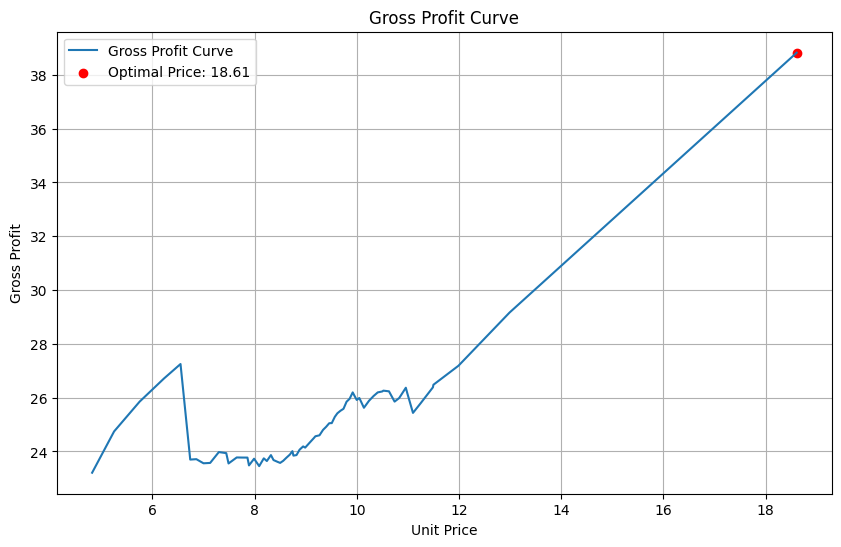

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(
    individuale_df['unit_price'], 
    individuale_df['gross_profit_predictions'], 
    label='Gross Profit Curve'
)
plt.scatter(
    optimal_price, 
    max_gross_profit, 
    color='red', 
    label=f'Optimal Price: {optimal_price:.2f}'
)
plt.title('Gross Profit Curve')
plt.xlabel('Unit Price')
plt.ylabel('Gross Profit')
plt.legend()
plt.grid(True)
plt.show()

# Step 8: Extend Sample Space

In [16]:
# Extend the range of unit prices
new_unit_prices = np.linspace(individuale_df['unit_price'].min(), 2 * individuale_df['unit_price'].max(), 100)

# Create a new DataFrame for the extended prices
extended_df = pd.DataFrame({
    'unit_price': new_unit_prices,
    'cost': individuale_df['cost'].mean(),
    'gross_margin': individuale_df['gross_margin'].mean()
})

# Add interaction features
extended_df['unit_price_squared'] = extended_df['unit_price'] ** 2
extended_df['unit_price_cost_interaction'] = extended_df['unit_price'] * extended_df['cost']

# Add scaled features
extended_df['unit_price_scaled'] = (extended_df['unit_price'] - individuale_df['unit_price'].mean()) / individuale_df['unit_price'].std()
extended_df['cost_scaled'] = (extended_df['cost'] - individuale_df['cost'].mean()) / individuale_df['cost'].std()

# Convert the extended DataFrame to an H2O frame
extended_h2o_df = h2o.H2OFrame(extended_df)

# Predict with the best model
new_preds = best_model.predict(extended_h2o_df)

# Convert predictions to pandas dataframe
new_predicted_quantities = h2o.as_list(new_preds)['predict']

# Calculate new gross profit predictions
new_gross_profits = (new_unit_prices - individuale_df['cost'].mean()) * new_predicted_quantities

# Find the optimal price in the extended range
optimal_price_extended = new_unit_prices[np.argmax(new_gross_profits)]
max_gross_profit_extended = max(new_gross_profits)
optimal_quantity_extended = new_predicted_quantities[np.argmax(new_gross_profits)]

print(f'Extended Optimal Price: {optimal_price_extended}')
print(f'Extended Maximum Gross Profit: {max_gross_profit_extended}')
print(f'Extended Optimal Quantity: {optimal_quantity_extended}')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


H2OServerError: HTTP 500 Server Error:
Server error java.lang.RuntimeException:
  Error: java.lang.AssertionError: Wrong number of parameters
  Request: None
  Stacktrace: java.lang.RuntimeException: java.lang.AssertionError: Wrong number of parameters
      water.util.Log.throwErr(Log.java:113)
      water.api.RapidsHandler.exec(RapidsHandler.java:38)
      sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
      sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
      sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
      java.lang.reflect.Method.invoke(Method.java:498)
      water.api.Handler.handle(Handler.java:60)
      water.api.RequestServer.serve(RequestServer.java:472)
      water.api.RequestServer.doGeneric(RequestServer.java:303)


# Plot the relationship between unit price and quantity with regression line

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(
    individuale_df['unit_price'], 
    individuale_df['quantity'], 
    alpha=0.5, 
    label='Actual Quantity'
)
plt.scatter(
    individuale_df['unit_price'], 
    individuale_df['predicted_quantity'], 
    color='red', 
    alpha=0.5, 
    label='Predicted Quantity'
)
plt.plot(
    new_unit_prices, 
    new_predicted_quantities, 
    color='blue', 
    linewidth=2, 
    label='Regression Line'
)
plt.title('Unit Price vs Quantity with Regression Line')
plt.xlabel('Unit Price')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()

# Plot the gross profit curve

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(
    individuale_df['unit_price'], 
    individuale_df['gross_profit_predictions'], 
    label='Gross Profit Curve'
)
plt.plot(
    new_unit_prices, 
    new_gross_profits, 
    label='Extended Gross Profit Curve'
)
plt.scatter(
    optimal_price, 
    max_gross_profit, 
    color='red', 
    label=f'Optimal Price: {optimal_price:.2f}'
)
plt.scatter(
    optimal_price_extended, 
    max_gross_profit_extended, 
    color='green', 
    label=f'Extended Optimal Price: {optimal_price_extended:.2f}'
)
plt.axhline(
    y=max_gross_profit_extended, 
    color='red', linestyle='--', 
    label=f'Max Gross Profit: {max_gross_profit_extended:.2f}'
)
plt.title('Gross Profit Curve')
plt.xlabel('Unit Price')
plt.ylabel('Gross Profit')
plt.legend()
plt.grid(True)
plt.show()

# Shutdown H2O

In [ ]:
h2o.cluster().shutdown()